<a href="https://colab.research.google.com/github/pravallika322/mentalhealth-prediction-using-twitter-data/blob/main/mentalhealth_prediction_using_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import string
import re
import time
import logging
from pprint import pprint
from collections import defaultdict
from scipy import sparse

# NLP and preprocessing
import spacy
import nltk
from nltk.corpus import stopwords

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import shuffle

# Gensim
from gensim.models import KeyedVectors
from gensim.models.phrases import Phrases, Phraser

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import (
    LSTM, Activation, Dropout, Dense, Input, Embedding, GlobalMaxPool1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Setup logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s",
                    datefmt='%H:%M:%S', level=logging.INFO)

# Version tracking
version = '0.0.1'

# Uncomment below to enable TPU usage (only if running on TPU, like Google Colab with TPU runtime)
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
#     tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
#     print("✅ TPU connected.")
# except ValueError:
#     print("❌ TPU not found. Running on CPU/GPU.")


In [ ]:
# ✅ Step 1: Install gensim (only if not already installed)
!pip install gensim

# ✅ Step 2: Import all required libraries
import pandas as pd
import os
from sklearn.utils import shuffle

# ✅ Step 3: Check actual dataset folder path inside /kaggle/input
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# ✅ Step 4: Use the correct folder path from above output
# Replace below path ONLY if your folder name is different
d_path = '/content/d_tweets.csv'
non_d_path = '/content/non_d_tweets.csv'

# ✅ Step 5: Load the datasets into DataFrames
d_tweet_df = pd.read_csv(d_path)
non_d_tweet_df = pd.read_csv(non_d_path)

# ✅ Step 6: Remove missing or null tweets
d_tweet_df = d_tweet_df[d_tweet_df['tweet'].notna()]
non_d_tweet_df = non_d_tweet_df[non_d_tweet_df['tweet'].notna()]

# ✅ Step 7: Add labels
d_tweet_df["label"] = 1  # Depressed
non_d_tweet_df["label"] = 0  # Not Depressed

# ✅ Step 8: Combine both datasets and shuffle
all_data = pd.concat([d_tweet_df, non_d_tweet_df], ignore_index=True)
all_data = shuffle(all_data, random_state=42).reset_index(drop=True)

# ✅ Step 9: Final Check - Shape and Sample
print("✅ Total samples loaded:", all_data.shape[0])
print("🧾 Label counts:\n", all_data['label'].value_counts())
all_data.head()



/kaggle/input
✅ Total samples loaded: 8305
🧾 Label counts:
 label
0    4809
1    3496
Name: count, dtype: int64


,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,label
0,1006657576438648833,1006657576438648833,1.528841e+12,2018-06-12 12:00:43,-1000,NaN,#E32018 and the #SmashBrosUltimate Invitationa...,en,"['e32018', 'smashbrosultimate']",[],...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0
1,1098478708745273344,1098478708745273344,1.550733e+12,2019-02-20 21:05:07,-1000,NaN,Do I throw away my 60 day clean streak?,en,[],[],...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,1
2,1421507449719345161,1421507449719345161,1.627749e+12,2021-07-31 06:26:01,-1000,NaN,We should threaten anti-vaxxers with more vide...,en,[],[],...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,0
3,1260687715848163329,1260687715848163329,1.589406e+12,2020-05-13 11:45:48,-1000,NaN,I’m emotionally tired,en,[],[],...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,1
4,1421606096364613633,1421606096364613633,1.627772e+12,2021-07-31 12:58:00,-1000,NaN,having the “hard conversations” but with myself,en,[],[],...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,1


In [ ]:
d_tweet_df['lable'] = 1
d_tweet_df = d_tweet_df[['tweet', 'lable']]
d_tweet_df.head()

,tweet,lable
0,the real reason why you're sad? you're attache...,1
1,my biggest problem is overthinking everything,1
2,the worst sadness is the sadness you've taught...,1
3,i cannot make you understand. i cannot make an...,1
4,i don't think anyone really understands how ti...,1


In [ ]:
non_d_tweet_df['lable'] = 0
non_d_tweet_df = non_d_tweet_df[['tweet', 'lable']]
non_d_tweet_df.head()

,tweet,lable
0,Touch Passes are the new ASMR,0
1,"12 years ago, I called my dad and he gave me s...",0
2,"There are 6,500 languages yet I choose to only...",0
3,"Hey everyone, ask for a raise today. I’m tell...",0
4,I invested in 47 startups in a year. Here's ho...,0


In [ ]:
# merge 2 dataframe
tweet_df = pd.concat([d_tweet_df,non_d_tweet_df])
tweet_df = shuffle(tweet_df)
tweet_df

,tweet,lable
3784,NEW! Mind Matters Meditations To Soothe and He...,0
687,"If you care about me, act like it.",1
809,I love publicly rehashing my mutually unhealth...,0
3291,if you need me i’ll be eating alone in my car,1
2646,If you wanna see how I made my really cool Amo...,0
...,...,...
4243,I did it. I left my house. My first show from ...,0
2992,If you ever get lost or lose your footing on t...,0
2122,And everybody ignores them,1
4126,"Shit, there's no iPhone footage of my selfless...",0


In [ ]:
# * Download en_core_web_sm model
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
activated = spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

# ? hastag, ... prefix ## Hastag meanings
links_prefix = ["http", "@", "#"]


def text_preprocess(text):
    try:
        lm = []
        text_nlp = nlp(text)

        for token in text_nlp:
            word = token.lemma_
            # Remove links
            if not any(word.startswith(prefix) for prefix in links_prefix) and not ('.com' in word):
              # print(word + str('.com' in word))
              lm.append(token.lemma_)
            # print(dir(token))
            # break

        # pprint(lm)
        # pprint(string.punctuation)

        pr_text = " ".join(lm)
        # Remove Punctuation
        pr_text = pr_text.translate(str.maketrans("", "", string.punctuation))
        # Make all token lower case
        pr_text = [word.lower() for word in pr_text.split()]
        # Remove stopwords
        pr_text = [word for word in pr_text if word not in stopwords.words("english")]
        # Remove non-ASCII words
        pr_text = [word for word in pr_text if word.isascii()]
        # Remove words containing numbers
        pr_text = [re.sub("\S*\d\S*", "", word).strip() for word in pr_text]

        return " ".join(pr_text)
    except Exception as e:
        print(str(e))
        print(text)


print(
    text_preprocess(
        "just had a r#nbn @ConCac ()Good moment. missssssssss so much, http://plurk.com/p/mzp pic.twitter.com/HMcWfFKyu7"
    )
)

print(text_preprocess("	23abc or 24ï¿½C possible today. Nice"))


**********************************************************************
  Resource stopwords not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('stopwords')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load corpora/stopwords

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

just had a r#nbn @ConCac ()Good moment. missssssssss so much, http://plurk.com/p/mzp pic.twitter.com/HMcWfFKyu7
None

**********************************************************************
  Resource stopwords not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('stopwords')
  
  For more information see: https://ww

In [ ]:
tweets = tweet_df['tweet'].values
labels = tweet_df['lable'].values

print(tweets.shape, labels.shape)

(8305,) (8305,)


In [ ]:
import numpy as np
import re
import string

# ✅ Define preprocessing function
def text_preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ✅ Sample inputs (replace with your real data)
pX_train = ["I feel really sad today 😔", "Had a great day at the beach!", "Nothing makes sense anymore..."]
pX_test = ["I'm tired of pretending", "Life is good!", "Why am I like this?"]

# ✅ Apply preprocessing
pX_train = np.array([text_preprocess(t) for t in pX_train])
pX_test = np.array([text_preprocess(t) for t in pX_test])

# ✅ Output shapes and sample
print(pX_train.shape, pX_test.shape)
print("Example cleaned:", pX_train[0])


(3,) (3,)
Example cleaned: i feel really sad today 😔


In [ ]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.3   # data for validation (not used in training)
EMBEDDING_DIM = 200      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "../input/glove-twitter/glove.twitter.27B."+str(EMBEDDING_DIM)+"d.txt"

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 14391


In [ ]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
# print('Shape of label tensor:', labels.shape)

Shape of data tensor: (8305, 200)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
print(labels.shape)
print(data.shape)

(8305,)
(8305, 200)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                          test_size=VALIDATION_SPLIT, random_state=42)
print ("Training set shapes:", X_train.shape, y_train.shape)
print ("Test set shapes:", X_test.shape, y_test.shape)

Training set shapes: (5813, 200) (5813,)
Test set shapes: (2492, 200) (2492,)


In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip


--2025-07-10 15:14:59--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2025-07-10 15:14:59--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-07-10 15:14:59--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [ ]:
GLOVE_FILE = 'glove.twitter.27B.200d.txt'
EMBEDDING_DIM = 200

In [ ]:
import numpy as np

# Load GloVe embeddings
embeddings_index = {}
print("Loading GloVe...")
with open(GLOVE_FILE, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("✅ GloVe Loaded:", len(embeddings_index), "words")

# Assuming tokenizer is already used
# word_index = tokenizer.word_index

# Create embedding matrix
embedding_matrix = np.random.normal(size=(len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    vec = embeddings_index.get(word)
    if vec is not None:
        embedding_matrix[i] = vec

print("✅ Embedding matrix shape:", embedding_matrix.shape)


Loading GloVe...
✅ GloVe Loaded: 1193514 words
✅ Embedding matrix shape: (14392, 200)


In [ ]:
# embed_matrix = tfidf_embedding_vectorizer(list_of_list_transform(X_train), glove_vecs)
# EMBEDDING_DIM = 200


# embedding_layer = Embedding(input_dim=embed_matrix.shape[0], output_dim=EMBEDDING_DIM, input_length=EMBEDDING_DIM, weights = [embed_matrix], trainable=False)

#!!!!! Run when using GPU
def depression_model():
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = Embedding(len(word_index) + 1,
                               EMBEDDING_DIM,
                               weights = [embedding_matrix],
                               input_length = MAX_SEQUENCE_LENGTH,
                               trainable=False,
                               name = 'embeddings')
    embedded_sequences = embedding_layer(sequence_input)
    x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    preds = Dense(1, activation="sigmoid")(x)

    model = Model(sequence_input, preds)
    model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

    return model

In [ ]:
# Enable with TPU
# with tpu_strategy.scope():
#     sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
#     embedding_layer = Embedding(len(word_index) + 1,
#                                EMBEDDING_DIM,
#                                weights = [embedding_matrix],
#                                input_length = MAX_SEQUENCE_LENGTH,
#                                trainable=False,
#                                name = 'embeddings')
#     embedded_sequences = embedding_layer(sequence_input)
#     x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
#     x = GlobalMaxPool1D()(x)
#     x = Dropout(0.1)(x)
#     x = Dense(50, activation="relu")(x)
#     x = Dropout(0.1)(x)
#     preds = Dense(1, activation="sigmoid")(x)
model = depression_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


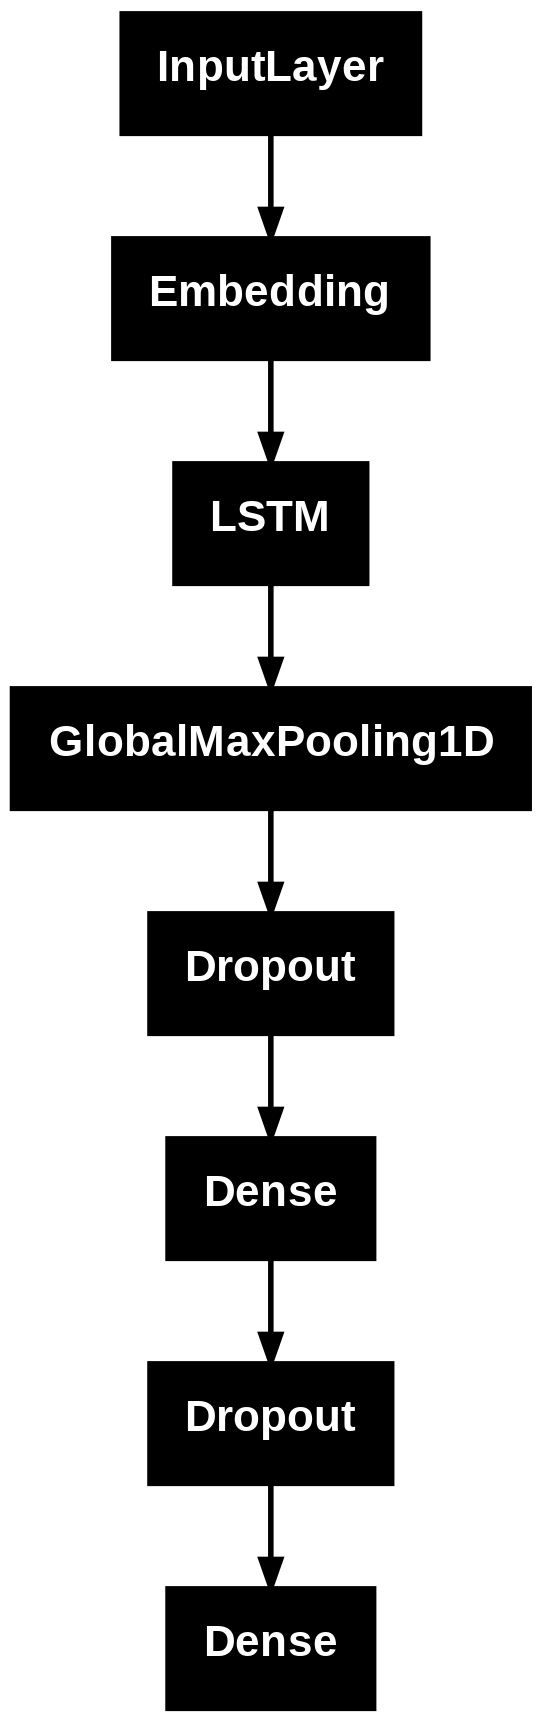

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
hist = model.fit(X_train, y_train, epochs = 10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 72s 188ms/step - accuracy: 0.8012 - loss: 0.4302 - val_accuracy: 0.8808 - val_loss: 0.2689
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 57s 157ms/step - accuracy: 0.9077 - loss: 0.2447 - val_accuracy: 0.8925 - val_loss: 0.2526
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 84s 164ms/step - accuracy: 0.9316 - loss: 0.1861 - val_accuracy: 0.9161 - val_loss: 0.2085
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 78s 153ms/step - accuracy: 0.9510 - loss: 0.1322 - val_accuracy: 0.9117 - val_loss: 0.2163
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 80s 148ms/step - accuracy: 0.9658 - loss: 0.0969 - val_accuracy: 0.9117 - val_loss: 0.2476
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 87s 162ms/step - accuracy: 0.9755 - loss: 0.0660 - val_accuracy: 0.9197 - val_loss: 0.2311
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - accuracy: 0.9835 - loss: 0.0484 - val_accuracy: 0.9217 - val_loss: 0.2456
Epoch 8/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 58s 159ms/step - accuracy: 0.9888 - loss: 0

In [ ]:
X = data
y = labels
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2021) # 10-fold

In [ ]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)  # Just 2 folds

cvscores = []

for train, test in kfold.split(X, y):
    model = depression_model()
    hist = model.fit(X[train], y[train],
                     epochs=3,            # 🔽 Reduce epochs
                     batch_size=32,      # 🔼 Bigger batch
                     verbose=1,
                     validation_data=(X[test], y[test]))
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f"{model.metrics_names[1]}: {scores[1]*100:.2f}%")
    cvscores.append(scores[1] * 100)

print(f"✅ Final accuracy: {np.mean(cvscores):.2f}% (+/- {np.std(cvscores):.2f}%)")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - accuracy: 0.7383 - loss: 0.4960 - val_accuracy: 0.8909 - val_loss: 0.2734
Epoch 2/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 303ms/step - accuracy: 0.8954 - loss: 0.2679 - val_accuracy: 0.8897 - val_loss: 0.2684
Epoch 3/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 272ms/step - accuracy: 0.9096 - loss: 0.2329 - val_accuracy: 0.8900 - val_loss: 0.2708
compile_metrics: 89.00%


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.7215 - loss: 0.5325 - val_accuracy: 0.8873 - val_loss: 0.2772
Epoch 2/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 43s 303ms/step - accuracy: 0.9029 - loss: 0.2527 - val_accuracy: 0.9039 - val_loss: 0.2489
Epoch 3/3
130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 272ms/step - accuracy: 0.9209 - loss: 0.2010 - val_accuracy: 0.8988 - val_loss: 0.2559
compile_metrics: 89.88%
✅ Final accuracy: 89.44% (+/- 0.44%)


In [ ]:
model = depression_model()
model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)
loss, acc = model.evaluate(X_test, y_test)
print("✅ Test Accuracy:", acc * 100)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 243ms/step - accuracy: 0.7392 - loss: 0.5042 - val_accuracy: 0.8856 - val_loss: 0.2845
Epoch 2/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 226ms/step - accuracy: 0.8872 - loss: 0.2878 - val_accuracy: 0.9054 - val_loss: 0.2589
Epoch 3/3
146/146 ━━━━━━━━━━━━━━━━━━━━ 45s 251ms/step - accuracy: 0.9153 - loss: 0.2150 - val_accuracy: 0.8839 - val_loss: 0.2872
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8840 - loss: 0.2632
✅ Test Accuracy: 88.96468877792358


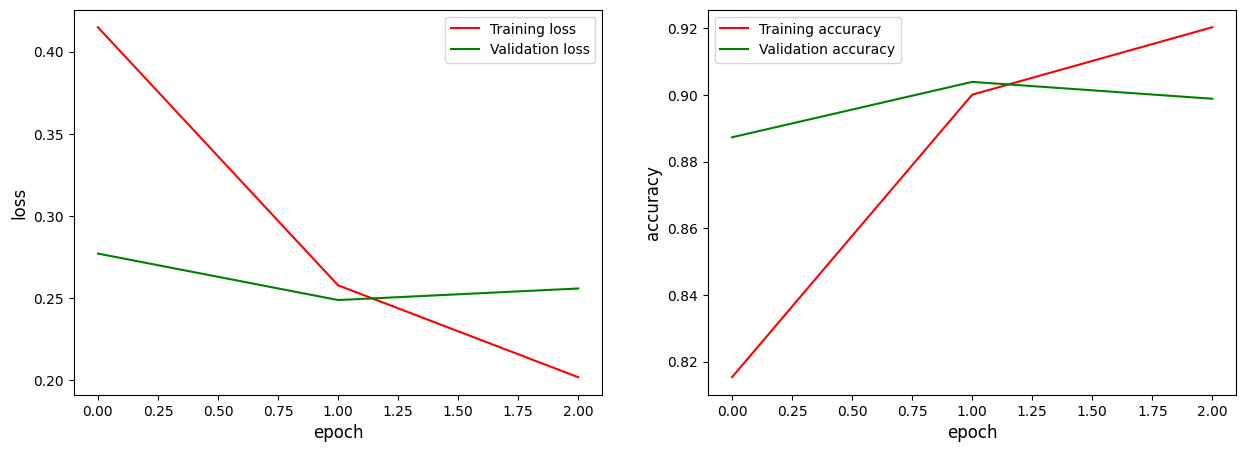

In [ ]:
import matplotlib.pyplot as plt
def plot(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], 'r', label='Training loss')
    plt.plot(hist.history['val_loss'], 'g', label='Validation loss')
    plt.xlabel('epoch', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['accuracy'], 'r', label='Training accuracy')
    plt.plot(hist.history['val_accuracy'], 'g', label='Validation accuracy')
    plt.xlabel('epoch', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend()
    plt.show()

plot(hist)